## Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, RepeatVector
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Dataset

### Importing Dataset

In [2]:
# Downloading the data
aapl_df = yf.download('AAPL')
aapl_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600


### Data Preprocessing

In [3]:
# Only keeping the close column
aapl_df = aapl_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Adding a column 'Prediction' which is shifted by 1 day
aapl_df['Prediction'] = aapl_df['Close'].shift(-1)

# Removing NA values
aapl_df = aapl_df.dropna()

aapl_df.head()

,Close,Prediction
Date,,
1980-12-12,0.128348,0.121652
1980-12-15,0.121652,0.112723
1980-12-16,0.112723,0.115513
1980-12-17,0.115513,0.118862
1980-12-18,0.118862,0.126116


In [4]:
# Extract dates for the test dataset
x_date = aapl_df.index[-math.ceil(len(aapl_df) * 0.2):]

In [5]:
in_scaler = MinMaxScaler()
out_scaler = MinMaxScaler()

# Scaling the data
x = in_scaler.fit_transform(aapl_df.drop(['Prediction'], axis=1))
y = out_scaler.fit_transform(aapl_df.drop(['Close'], axis=1))


### Creating Dataset

In [6]:
sequence_length = 42
train_len = math.ceil(len(aapl_df) * 0.6)
val_len = math.ceil(len(aapl_df) * 0.2)

# Splitting the data into train, validation and test sets
x_train = x[:train_len, :]
y_train = y[:train_len, :]

x_val = x[train_len - sequence_length:train_len + val_len, :]
y_val = y[train_len - sequence_length:train_len + val_len, :]

x_test = x[train_len + val_len - sequence_length:, :]
y_test = y[train_len + val_len - sequence_length:, :]

In [7]:
def create_dataset(x, y, sequence_length):
    x_data = []
    y_data = []
    for i in range(sequence_length, len(x)):
        x_data.append(x[i - sequence_length:i, :])
        y_data.append(y[i, :])
    return np.array(x_data), np.array(y_data)


# Creating the dataset
x_train, y_train = create_dataset(x_train, y_train, sequence_length)
x_val, y_val = create_dataset(x_val, y_val, sequence_length)
x_test, y_test = create_dataset(x_test, y_test, sequence_length)

## Model Building and Training

In [8]:
def USLSTMA():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(RepeatVector(x_train.shape[1]))
    model.add(LSTM(x_train.shape[1], return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [9]:
model = USLSTMA()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 repeat_vector (RepeatVector  (None, 42, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 42)                17976     
                                                                 
 dense (Dense)               (None, 1)                 43        
                                                                 
Total params: 34,915
Trainable params: 34,915
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('../Saved Models/uslstma.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

epochs = 100
batch_size = 16

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, checkpoint],
)


Epoch 1/100
396/396 [==============================] - ETA: 0s - loss: 2.8992e-06
Epoch 00001: val_loss improved from inf to 0.00001, saving model to ../Saved Models\uslstma.h5
396/396 [==============================] - 21s 40ms/step - loss: 2.8992e-06 - val_loss: 6.6509e-06
Epoch 2/100
396/396 [==============================] - ETA: 0s - loss: 8.1225e-08
Epoch 00002: val_loss did not improve from 0.00001
396/396 [==============================] - 14s 34ms/step - loss: 8.1225e-08 - val_loss: 7.3522e-06
Epoch 3/100
396/396 [==============================] - ETA: 0s - loss: 1.2107e-07
Epoch 00003: val_loss did not improve from 0.00001
396/396 [==============================] - 14s 34ms/step - loss: 1.2107e-07 - val_loss: 8.5677e-06
Epoch 4/100
396/396 [==============================] - ETA: 0s - loss: 1.1240e-07
Epoch 00004: val_loss did not improve from 0.00001
396/396 [==============================] - 14s 35ms/step - loss: 1.1240e-07 - val_loss: 6.8276e-06
Epoch 5/100
396/396 [=======

## Model Evaluation

In [11]:
predicitons = model.predict(x_test)
predictions = out_scaler.inverse_transform(predicitons)
actual = out_scaler.inverse_transform(y_test)

# Calculating the error
error = predictions - actual
mse = np.square(error).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
mape = np.abs(error / actual).mean() * 100

# Printing the error
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)

67/67 [==============================] - 2s 15ms/step
Mean Squared Error:  101.85513888214449
Root Mean Squared Error:  10.092330696233873
Mean Absolute Error:  5.827403935069921
Mean Absolute Percentage Error:  5.378459168859797


## Model Prediction and Visualization

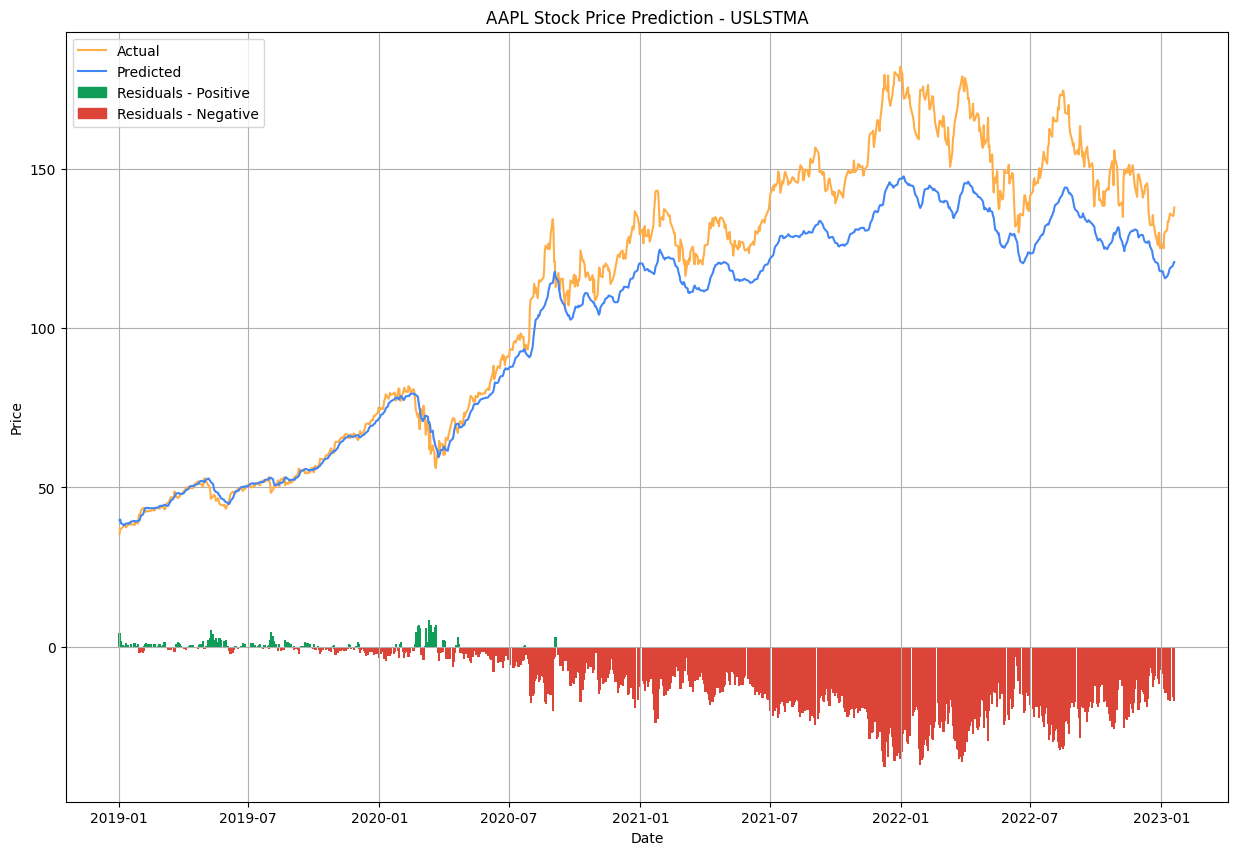

In [15]:
# Creating a dataframe for the predictions, actual values and residuals
prediction_df = pd.DataFrame({'Actual': actual.flatten(
), 'Predicted': predictions.flatten(), 'Residuals': error.flatten()}, index=x_date)

# Taking data from 2019-01-01
predictions_df = prediction_df.loc['2019-01-01':]

# Plotting the data and residuals bars in the same plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions_df.index,
        predictions_df['Actual'], label='Actual', color='#FFAD46', linewidth=1.5)
ax.plot(predictions_df.index,
        predictions_df['Predicted'], label='Predicted', color='#4285F4', linewidth=1.5)

df_sub = ["#0F9D58" if x >
          0 else "#DB4437" for x in predictions_df["Residuals"].dropna()]
ax.bar(predictions_df.index, predictions_df['Residuals'].dropna(
), width=3, label='Residuals', color=df_sub)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Stock Price Prediction - USLSTMA')

Patch = mpatches.Patch
legend_elements = [Line2D([0], [0], color='#FFAD46', lw=1.5, label='Actual'),
                   Line2D([0], [0], color='#4285F4',
                          lw=1.5, label='Predicted'),
                   Patch(facecolor='#0F9D58', edgecolor='#0F9D58',
                         label='Residuals - Positive'),
                   Patch(facecolor='#DB4437', edgecolor='#DB4437', label='Residuals - Negative')]
ax.legend(handles=legend_elements, loc='upper left')

ax.grid(True)
plt.show()